# Assignment 8

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [221]:
df=pd.read_csv('/content/monthly_milk_production.csv')

In [222]:
df.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [223]:
df.Date=pd.to_datetime(df.Date)

In [224]:
df.dropna()

,Date,Production
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727
...,...,...
163,1975-08-01,858
164,1975-09-01,817
165,1975-10-01,827
166,1975-11-01,797


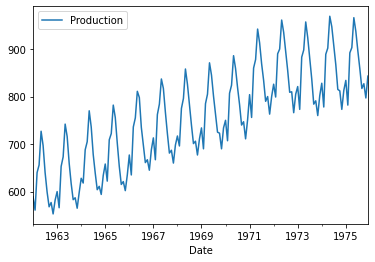

In [225]:
df.plot(x='Date', y='Production')

In [226]:
timeseries = df['Production']

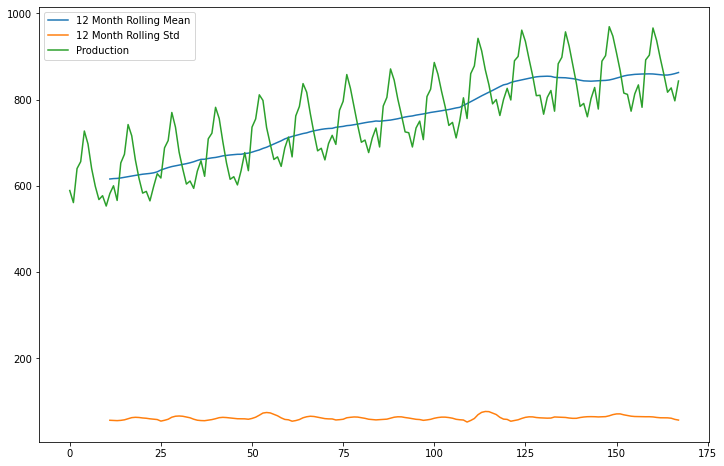

In [227]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot(figsize = (12,8))
plt.legend();

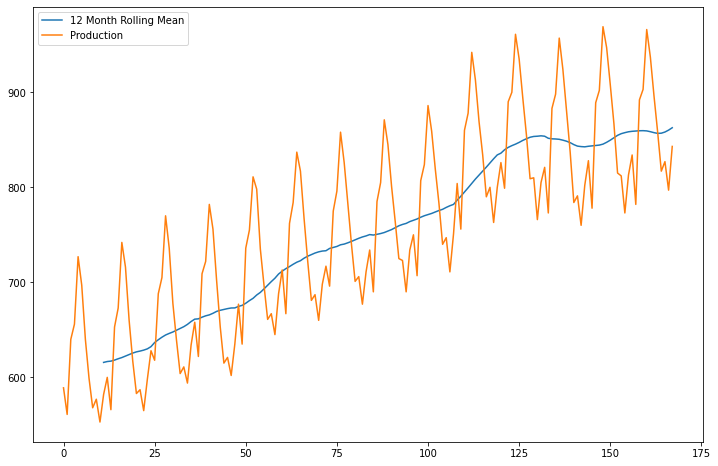

In [228]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot(figsize = (12,8))
plt.legend();

<ipython-input-229-0b2709be32de>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(df['Production'], freq=12)


<Figure size 432x288 with 0 Axes>

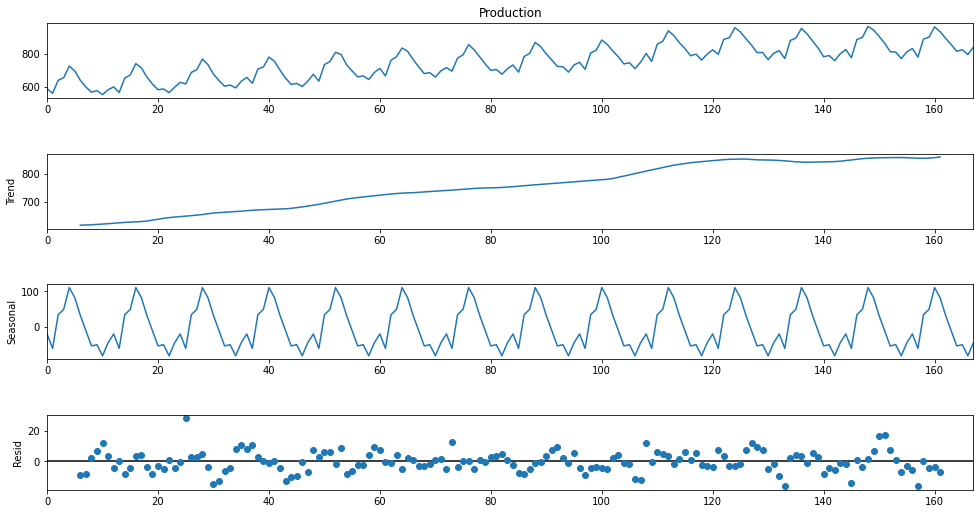

In [229]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Production'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [230]:
from statsmodels.tsa.stattools import adfuller

In [231]:
result = adfuller(df['Production'])

In [232]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.3038115874221246
p-value : 0.627426708603034
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [233]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [234]:
df['Milk First Difference'] = df['Production'] - df['Production'].shift(1)

In [235]:
adf_check(df['Milk First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.0549955586531095
p-value : 0.0300680040017824
#Lags Used : 14
Number of Observations Used : 152
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


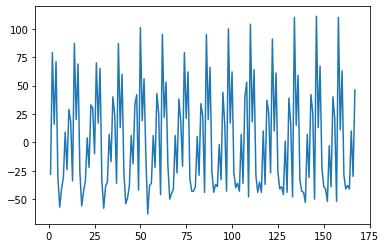

In [236]:
df['Milk First Difference'].plot()

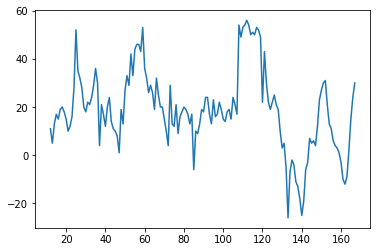

In [237]:
df['Seasonal Difference'] = df['Production'] - df['Production'].shift(12)
df['Seasonal Difference'].plot()

In [238]:
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.335419314359397
p-value : 0.16079880527711382
#Lags Used : 12
Number of Observations Used : 143
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


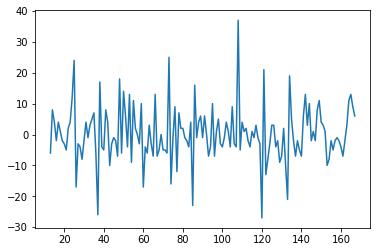

In [239]:
df['Seasonal First Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(12)
df['Seasonal First Difference'].plot()

In [240]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.038002274921979
p-value : 1.865423431878876e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


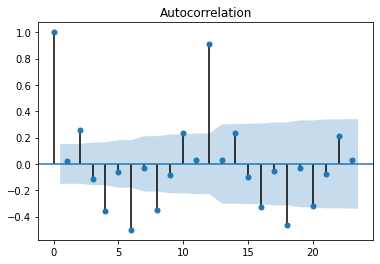

In [241]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig_first = plot_acf(df["Milk First Difference"].dropna())

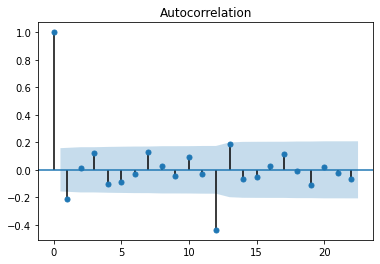

In [242]:
fig_seasonal_first = plot_acf(df["Seasonal First Difference"].dropna())

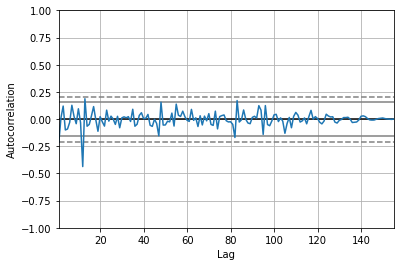

In [243]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Seasonal First Difference'].dropna())

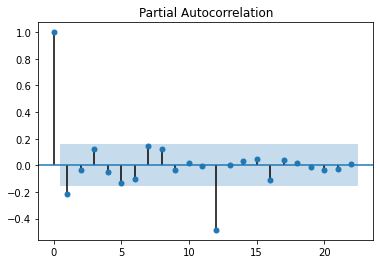

In [244]:
result = plot_pacf(df["Seasonal First Difference"].dropna())

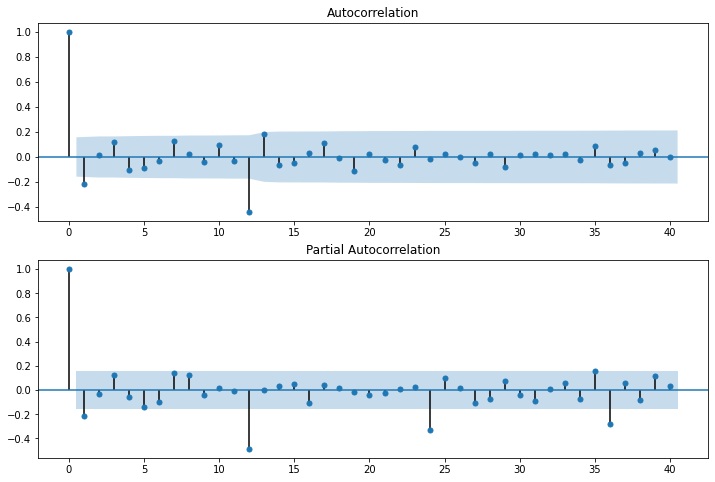

In [245]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax2)

In [246]:
model = sm.tsa.statespace.SARIMAX(df['Production'],order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Production   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -534.065
Date:                              Sat, 14 Jan 2023   AIC                           1074.131
Time:                                      18:21:40   BIC                           1083.261
Sample:                                           0   HQIC                          1077.839
                                              - 168                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.58

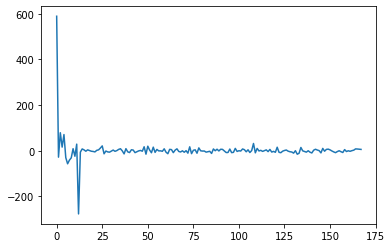

In [247]:
results.resid.plot()

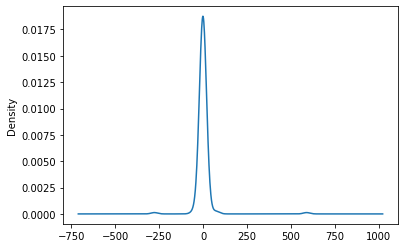

In [248]:
results.resid.plot(kind='kde')

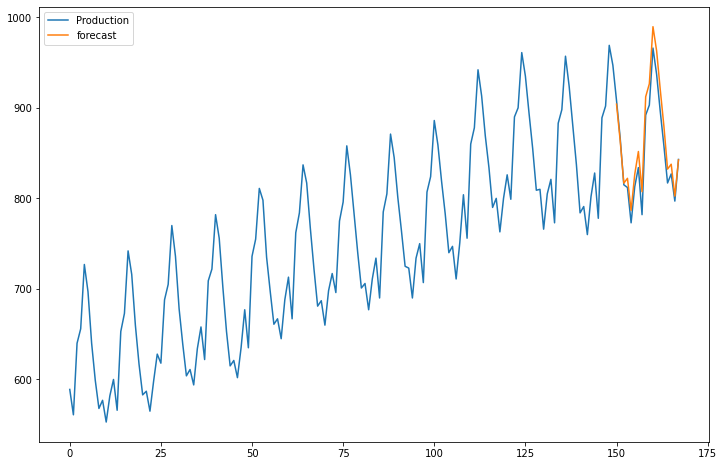

In [249]:
df['forecast'] = results.predict(start = 150, end= 168, dynamic= True)  
df[['Production','forecast']].plot(figsize=(12,8))

In [250]:
from pandas.tseries.offsets import DateOffset

In [251]:
future_dates = [df.iloc[-1]["Date"] + DateOffset(months = x) for x in range (0,60)]

In [252]:
future_dates_df = pd.DataFrame(future_dates,columns=['Date'])

In [253]:
future_df = pd.concat([df,future_dates_df])

In [254]:
future_df.head()

,Date,Production,Milk First Difference,Seasonal Difference,Seasonal First Difference,forecast
0,1962-01-01,589.0,NaN,NaN,NaN,NaN
1,1962-02-01,561.0,-28.0,NaN,NaN,NaN
2,1962-03-01,640.0,79.0,NaN,NaN,NaN
3,1962-04-01,656.0,16.0,NaN,NaN,NaN
4,1962-05-01,727.0,71.0,NaN,NaN,NaN


In [255]:
future_df.tail()

,Date,Production,Milk First Difference,Seasonal Difference,Seasonal First Difference,forecast
55,1980-07-01,NaN,NaN,NaN,NaN,NaN
56,1980-08-01,NaN,NaN,NaN,NaN,NaN
57,1980-09-01,NaN,NaN,NaN,NaN,NaN
58,1980-10-01,NaN,NaN,NaN,NaN,NaN
59,1980-11-01,NaN,NaN,NaN,NaN,NaN


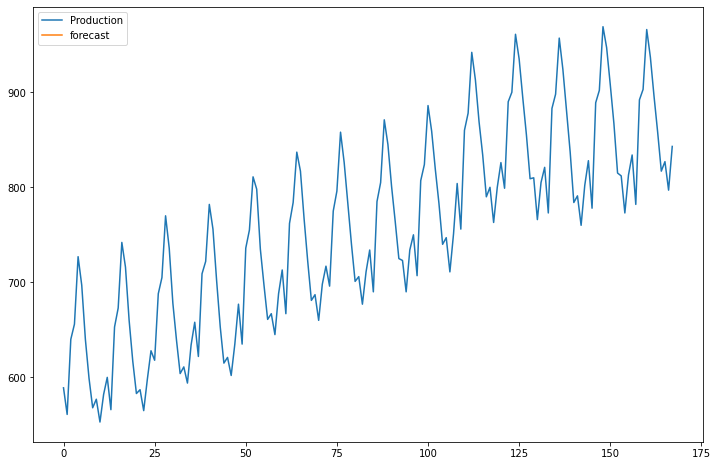

In [256]:
future_df['forecast'] = results.predict(start = 168, end = 200, dynamic= True)  
future_df[['Production', 'forecast']].plot(figsize=(12, 8)) 